# Weryfikacja efektywności implementacji metod optymalizacji gradientowej
### Łukasz Knigawka & Grzegorz Kopyt
### 2021L

W notatniku przedstawiono eksperymenty z optymalizacją gradientową przy wykorzystaniu języka programowania Julia. 

Jako środowisko uruchomieniowe wykorzystano Google Colab. 
Instalację Julia i wykorzystanie procesorów graficznych dostępnych na platformie przedstawiono poniżej. Domyślnie przy wybraniu akceleracji przy pomocy GPU na Google Colab otrzymujemy niespełna 13GB RAM. Łatwo możemy jednak uzyskać zwiększenie tej wielkości do 25GB -- wystarczy przekroczyć próg ~13GB. Wtedy będziemy niestety musieli od nowa uruchomić komórki, gdyż sesja zostanie zrestartowana. Oczywiście przekroczyć ~13GB jest łatwo, możemy zaalokować ogromną tablicę na starcie i mamy 25GB RAM za darmo (więcej niż na naszych prywatnych komputerach) :) Dodatkową zaletą jest fakt, że współdzielenie środowiska umożliwia dokonywanie pomiarów na tej samej konfiguracji sprzętowej przez obu członków zespołu projektowego.

 Przy realiacji projektu wykorzystywana jest wersja Julii 1.6.0.

## Konfiguracja środowiska uruchomieniowego

In [2]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.6* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU). 

<br/>You should see something like this:

> ![Colab Img](https://raw.githubusercontent.com/Dsantra92/Julia-on-Colab/master/misc/julia_menu.png)

<br/>Click on SAVE
<br/>**We are ready to get going**





In [1]:
VERSION

v"1.6.0"

**The next three cells are for GPU benchmarking. If you are using this notebook for the first time and have GPU enabled, you can give it a try.** 

###GPU Experiments

In [ ]:
using Pkg
Pkg.add(["BenchmarkTools", "CUDA"])
using BenchmarkTools, CUDA

if has_cuda_gpu()
  print("The GPU device is:", CUDA.device())
end

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed OpenSpecFun_jll ──── v0.5.4+0
   Installed Memoize ──────────── v0.4.4
   Installed OrderedCollections ─ v1.4.0
   Installed MacroTools ───────── v0.5.6
   Installed BenchmarkTools ───── v0.7.0
   Installed SpecialFunctions ─── v1.3.0
   Installed DataStructures ───── v0.18.9
   Installed Compat ───────────── v3.27.0
   Installed Adapt ────────────── v3.3.0
   Installed AbstractFFTs ─────── v1.0.1
   Installed Requires ─────────── v1.1.3
   Installed ChainRulesCore ───── v0.9.40
   Installed LLVM ─────────────── v3.6.0
   Installed RandomNumbers ────── v1.4.0
   Installed CUDA ─────────────── v3.1.0
   Installed Reexport ─────────── v1.0.0
   Installed TimerOutputs ─────── v0.5.8
   Installed Scratch ──────────── v1.0.3
   Installed BFloat16s ────────── v0.1.0
   Installed CEnum ────────────── v0.4.1
   Installed ExprTools ────────── v0.1.3
   Installed GPUArrays ────────── v6.3.0
   In

The GPU device is:CuDevice(0)

In [ ]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

BenchmarkTools.Trial: 
  memory estimate:  8.00 MiB
  allocs estimate:  2
  --------------
  minimum time:     52.392 ms (0.00% GC)
  median time:      55.926 ms (0.00% GC)
  mean time:        56.584 ms (0.60% GC)
  maximum time:     69.505 ms (3.02% GC)
  --------------
  samples:          89
  evals/sample:     1

In [ ]:
println("The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CUDA.@sync mgpu*mgpu

The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.


BenchmarkTools.Trial: 
  memory estimate:  6.23 KiB
  allocs estimate:  358
  --------------
  minimum time:     377.307 μs (0.00% GC)
  median time:      536.563 μs (0.00% GC)
  mean time:        545.880 μs (0.65% GC)
  maximum time:     17.698 ms (67.05% GC)
  --------------
  samples:          9078
  evals/sample:     1

# Opis projektu (źródło: isod)

Celem projektu jest zweryfikowanie implementacji algorytmów optymalizacji gradientowej przedstawionych w [1]:

- BFGS,
- L-BFGS (Limited Memory BFGS),
- któryś z: Gradient Descent, RMSprop, Nesterov Momentum, Adam, Adadelta, Adagrad.

W ramach projektu należy ocenić czy możliwa jest bardziej efektywna implementacja tych algorytmów. Polegać to będzie na Przykładowo: dla implementacji w języku Julia należy zadbać m.in. o stabilność typów funkcji, wykorzystanie typów konkretnych w definicji struktur i funkcji. W języku Python niezbędne jest wykorzystanie modułu Numba i ogólna inspekcja kodu LLVM.

Porównaniu powinny podlegać: czas znalezienia rozwiązania (z ustaloną dokładnością ϵ

), liczba potrzebnych iteracji oraz ilość allokowanej pamięci w trakcie działania algorytmu. Przeprowadzone porównanie powinno testować wspominane algorytmy w kilku wariantach: tradycyjnych, dwuwymiarowych funkcji celu jak i wielowymiarowych funkcji celu (co najmniej czterowymiarowych).

Tradycyjne, ciekawe funkcje celu to, np.:

- funkcja Rosenbrocka,
- grzbiet Wheelera (ang. Wheeler’s Ridge function),
- funkcja Michalewicza.

Dobrym przykładem wielowymiarowych funkcji celu jest optymalizacja wag w sieciach neuronowych.

Raport końcowy powinien składać się z czterech części:

1. wstępu precyzującego jakie algorytmy i w jakim języku zostały zaimplementowane;
2. opisu badania, przedstawiającego wybrane przypadki testowe, aspekty porównania oraz (najważniejsze) sposoby i warunki ich pomiaru; w warunkach pomiaru proszę uwzględnić parametry środowiska uruchomieniowego: rozmiar i prędkość pamięci, model procesora, model i typ dysku; niezbędne jest wyszczególnienie wszystkich zastosowanych optymalizacji algorytmów;
3. sekcji z wynikami przedstawionymi w odpowiedniej formie wizualnej;
4. podsumowania, odnoszącego się do wyników, obiektywnie zestawiających cechy charakterystyczne tych algorytmów; należy skonfrontować uzyskane wyniki ze spodziewanymi; warto odnieść się w dyskusji do aspektu związane z implementacją algorytmów.

W raporcie końcowym należy załączyć wykresy prezentujące zbieżność porównywanych algorytmów: najlepiej w postaci narysowanych ścieżek na dwuwymiarowym wykresie z zaznaczoną mapą wysokości testowanej funkcji celu -- tylko dla funkcji dwuwymiarowych. Dla testu funkcji o większej wymiarowości należy zastosować wykres wartości funkcji celu od numeru kroku w skali podwójnie logarytmicznej.

[1]:  Mykel J. Kochenderfer, Tim A. Wheeler, 2019, Algorithms for Optimization, MIT Press.

Sekcje teoretyczne powstają głównie w oparciu o wykład z przedmiotu *Algorytmy w Inżynierii Danych*.

[comment]: # (ponizsze punkty to takie, które wg isod powinny się znaleźć w sprawozdaniu końcowym -- jak zaczniemy tutaj nasze przemyślenia/nawet luźniejsze teksty przyporządkowywać do tych sekcji, to łatwiej będzie to pozbierać w końcowe sprawozdanie)
# Opis problemu

Zadaniem algorytmów optymalizacyjnych jest przeszukanie przestrzeni rozwiązań w celu znalezienia takiego, którego wartość funkcji celu jest najmniejsza.
Aby odnaleźć punkt optymalny, algorytmy optymalizacji mogą polegać na gradiencie i macierzy Hessego (drugich pochodnych) funkcji celu. Optymalizaując wiele parametrów, część z nich może się okazać mało istotna w poszukiwaniu punktu optymalnego. 

Metody pierwszego rzędu opierają się na informacji o gradiencie optymalizowanej funkcji. 


# Wprowadzenie do zastosowanych metod

BFGS ==  Broyden–Fletcher–Goldfarb–Shanno


# Przegląd dostępnych metod



# Charakterystyka wybranych metod 

[comment]: # (cechy, właściwości graniczne, zbieżnosć, wrażliwość na błędy danych wejściowych)



# Co testujemy?

[comment]: # (przedstawienie elementów, które będą testowane z uwypukleniem tez, które będą udowadniane w trakcie eksperymentów)


# Implementacja (opis)

[comment]: # (przedstawienie projektu i krótko implementacji eksperymentu - co i jak będzie testowane, chciałbym kod zawrzeć dalej, a w tym miejscu jedynie opisać implementację)



## O czym pamiętać pisząc efektywne algorytmy? (na podstawie Wykładu 08)
Opracowanie powstało, aby zebrać informacje nt. pisania efektywnego kodu w Julii i wiedzę tę wykorzystać przy projekcie. 
- W Julii mamy makro `@time`, które bada czas działania i rozmiar alokowanej pamięci.
- Pakiet `BenchmarTools` posiada makro `@btime`, które wielokrotnie uruchamia kod. Importujemy przy pomocy `import BenchmarkTools: @btime`, następnie w wybranej linijce na początku zawieramy makro. Na przykład `@btime copy_row_col!(out, x);`
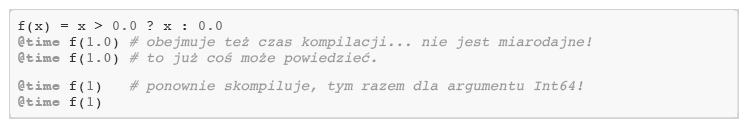
- Gdzie tylko możemy, deklarujmy typu zmiennych/obiektów, nawet jeśli da się to ominąć.
- Domyślnie wycinanie kawałka macierzy tworzy kopię. Rezygnacja z kopiowania na rzecz widoku może przyspieszyć program. Dla wygody możemy skorzystać z makra `@views` , które automatycznie zamienia kopiowanie na
tworzenie widoku. Przykładowe użycie: `@views fview(x) = sum(x[2:end-1]);`.


# Implementacje (kod)
Implemetacje algorytmów zaproponowane w pozycji [1] dostępne są pod [tym](https://github.com/sisl/algforopt-notebooks) adresem.




## Metody pierwszego rzędu



## Metody drugiego rzędu


## Adam


In [2]:
mutable struct Adam <: DescentMethod
α # learning rate
ε # small value
v # sum gradient
s # sum of squared gradient
γs # gradient decay
γv # momentum decay
k # step counter
Adam() = new() # new uninitialized structure
end

function init!(M::Adam, θ; α=0.001, γv=0.9, γs=0.999, ε=1e-8)
M.α = α
M.ε = ε
M.γs = γs
M.γv = γv
M.s = zero(θ)
M.v = zero(θ)
M.k = 0
return M
end

function step!(M::Adam, f, ∇f, θ)
γs, γv = M.γs, M.γv
α, ε, k = M.α, M.ε, M.k
s, v, g = M.s, M.v, ∇f(θ)
v[:] = γv*v + (1.0 - γv) * g
s[:] = γs*s + (1.0 - γs) * g .* g
M.k = k += 1
v̂ = v ./ (1.0 - γv^k)
ŝ = s ./ (1.0 - γs^k)
return θ - α*v̂ ./ (sqrt.(ŝ) .+ ε)
end

LoadError: ignored

## TODO:
- odnaleźć w repo na githubie z notebookami od autorów ksiązki przydatne nam implementacje (BFGS/Limited Memory BFGS/Adam/...)
- opracować wstęp teoretyczny, w którym zorientujemy się głębiej w temacie optymalizacji gradientowej
- przygotować sekcję na temat pomiarów wydajności (zużycie CPU/GPU/...) na Google Colab
- ...